In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv ('data\Disneyland-all.csv')
df.drop('Review_ID', axis=1, inplace = True)
df = df[df['Year_Month'] != "missing"]
df['year'] = pd.DatetimeIndex(df['Year_Month']).year
df['year'] = pd.to_numeric(df['year'])
df['month'] = pd.DatetimeIndex(df['Year_Month']).month
df['month'] = pd.to_numeric(df['month'])
df.drop('Year_Month', axis=1, inplace = True)
df = df.reset_index(drop=True)
df.head(5)

,Rating,Reviewer_Location,Review_Text,Branch,year,month
0,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4
1,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4
4,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4


First, extract reviews only

In [3]:
reviews = df['Review_Text']

#### Pre-processing

In [4]:
#strip ascii characters
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

#only interested in reviews written in English
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
    if lang == 'english':
        return True
    else:
        return False

In [5]:
#change type to string
reviews = reviews.astype('str')

In [6]:
eng_rev = reviews[reviews.apply(get_language)]
#eng_rev.head()
print(len(eng_rev)) #5 reviews not in english

40031


In [7]:
#remove duplicates if any
eng_rev.drop_duplicates(inplace=True)
len(eng_rev) 

40011

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
#lemmatize
def clean_comments(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    #use spacy to lemmatize comments
    doc = nlp(nopunct, disable=['parser','ner'])
    lemmatized = [token.lemma_ for token in doc]
    return lemmatized

In [10]:
#apply function to clean and lemmatize comments
lemm = eng_rev.map(clean_comments)

#lowercase words
lemm = lemm.map(lambda x: [word.lower() for word in x])

In [11]:
#turn all comments' tokens into one single list
unlist_rev = [item for items in lemm for item in items]
#unlist_rev = [x.strip('') for x in unlist_rev]
#unlist_rev.head()


In [12]:
#remove stopwords
stop_words = set(stopwords.words('english')) 
  
cleaned_rev = [w for w in unlist_rev if not w in stop_words] 

#remove spaces
cleaned_rev = [w for w in cleaned_rev if w != ' '] 
cleaned_rev = [w for w in cleaned_rev if w != '  '] 
cleaned_rev = [w for w in cleaned_rev if w != '   ']
#cleaned_rev

In [13]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(cleaned_rev)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(cleaned_rev)

In [14]:
bigram_freq = bigramFinder.ngram_fd.items()

In [15]:
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

In [16]:
bigramFreqTable.head(30).reset_index(drop=True)

,bigram,freq
0,"(fast, pass)",7146
1,"(year, old)",3954
2,"(space, mountain)",3417
3,"(hong, kong)",3119
4,"(go, back)",3009
5,"(disneyland, paris)",2863
6,"(wait, time)",2853
7,"(one, day)",2834
8,"(visit, disneyland)",2701
9,"(disney, world)",2700


In [17]:
#might be more meaningful if we can get adjectives and nouns 

#function to filter for ADJ/NN bigrams

def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [18]:
#takes awhile to run
bigram_filter = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
bigram_filter.head(10)

,bigram,freq
78,"(space, mountain)",3417
5,"(hong, kong)",3119
4110,"(disneyland, paris)",2863
1733,"(wait, time)",2853
2850,"(visit, disneyland)",2701
285,"(disney, world)",2700
138,"(theme, park)",2680
604,"(disney, park)",2342
594,"(great, time)",2156
57265,"(california, adventure)",2146


In [19]:
test_string = bigram_filter['bigram'].tolist()
test_string[1]
#type(test_string)
#combine tuple
test_string[1][0] +'_' + test_string[1][1] 

#combine all tuples in df
bigram = [ ]
for c in range(0, len(test_string)):
    bigram.append(test_string[c][0] +'_' + test_string[c][1]) 

bigram_filter['bigram_combo'] = bigram

<ipython-input-19-1450060eecf2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigram_filter['bigram_combo'] = bigram


In [20]:
top20_bigram = bigram_filter[:20]

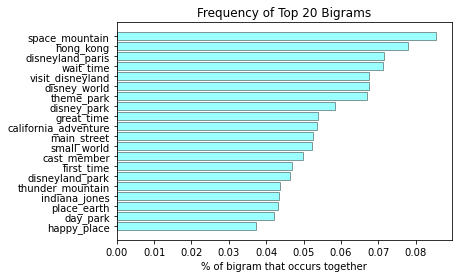

In [21]:
plt.barh(top20_bigram['bigram_combo'], top20_bigram['freq']/len(df), color ='cyan', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of bigram that occurs together")
plt.gca().invert_yaxis()
plt.title("Frequency of Top 20 Bigrams")
#plt.savefig("output\disney_topbigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

### Do the same for trigrams

In [22]:
trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable.head(5).reset_index(drop=True)

,trigram,freq
0,"(happy, place, earth)",1207
1,"(get, fast, pass)",1104
2,"(use, fast, pass)",1003
3,"(hong, kong, disneyland)",930
4,"(big, thunder, mountain)",899


In [23]:
#filter NN and ADJ in trigrams
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [24]:
trigram_filter = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]
trigram_filter.head(10)

,trigram,freq
685,"(happy, place, earth)",1207
6698,"(use, fast, pass)",1003
7012,"(big, thunder, mountain)",899
406992,"(california, adventure, park)",487
21565,"(visit, disneyland, paris)",483
403957,"(day, park, hopper)",472
4884,"(year, old, daughter)",454
361511,"(disneyland, california, adventure)",439
2463,"(walt, disney, world)",412
1411,"(toy, story, land)",411


In [25]:
test_string2 = trigram_filter['trigram'].tolist()

trigram = [ ]
for c in range(0, len(test_string2)):
    trigram.append(test_string2[c][0] + '_' + test_string2[c][1] + '_' + test_string2[c][2]) 

trigram_filter['trigram_combo'] = trigram
top20_trigram = trigram_filter[:20]

<ipython-input-25-d824e74f30d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trigram_filter['trigram_combo'] = trigram


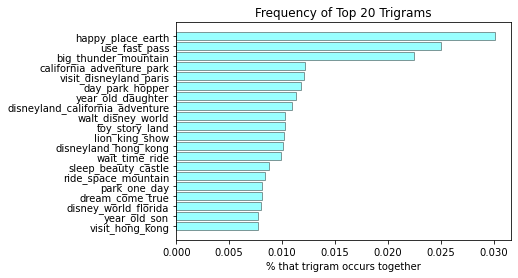

In [27]:
#plot frequency of trigram that occurs out of all ca reviews
plt.barh(top20_trigram['trigram_combo'], top20_trigram['freq']/len(df), color ='cyan', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% that trigram occurs together")
plt.gca().invert_yaxis()
#plt.ylabel("Counts")
plt.title("Frequency of Top 20 Trigrams")
#plt.savefig("output\disney_hk_toptrigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

- Trigram shows a lot more! Which rides/attractions they went to, what kind of tickets they purchased, duration of stay/visit
    1. Anaheim - many talk about fast passes, waiting times, rides, type of ticket
        - "happiest place on earth!" (does this mean that reviews about ca are more subjective than other locations?)
    2. Paris - got info about disney hotel, rides, not as much fast pass or talking about being in line, characters, type of ticket, extra magic hour
    3. HK - attractions, queues
- Compare what visitors are saying about rides from each park; 
    1. Anaheim - space_mountain, indiana_jones, splash_mountain, small_world
    2. Paris - space_mountain, (big) thunder_mountain, small_world, peter pan, sleeping beauty
    3. HK - lion_king, grizzly mountain, toy story

## Now, find reviews where top n ngram is used and analyze sentiment/emotions about rides, park experience

In [28]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def detect_tb_polarity(text):
    return TextBlob(text).sentiment.polarity

def detect_tb_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def detect_vader_pos(text):
    return vader.polarity_scores(text)['pos']

def detect_vader_neg(text):
    return vader.polarity_scores(text)['neg']

def detect_vader_comp(text):
    return vader.polarity_scores(text)['compound']

In [29]:
df['tb_polarity'] = df.Review_Text.apply(detect_tb_polarity)
df['tb_subjectivity'] = df.Review_Text.apply(detect_tb_subjectivity)

vader = SentimentIntensityAnalyzer()
df['vader_pos'] = df.Review_Text.apply(detect_vader_pos)
df['vader_neg'] = df.Review_Text.apply(detect_vader_neg)
df['vader_comp'] = df.Review_Text.apply(detect_vader_comp)

In [30]:
#assign sentiment based on compound score
df['sentiment'] = np.where(df['vader_comp'] >= 0.05, 'positive', 'negative')

In [31]:
df.head(10)

,Rating,Reviewer_Location,Review_Text,Branch,year,month,tb_polarity,tb_subjectivity,vader_pos,vader_neg,vader_comp,sentiment
0,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,0.243981,0.561481,0.109,0.000,0.7069,positive
1,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,0.236131,0.434649,0.195,0.044,0.9853,positive
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,0.160498,0.422944,0.220,0.022,0.9920,positive
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,0.189286,0.512143,0.154,0.078,0.8425,positive
4,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,0.266667,0.437500,0.098,0.000,0.2846,positive
5,3,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong,2019,4,-0.065476,0.610397,0.154,0.088,0.9311,positive
6,5,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,2019,4,0.185000,0.590000,0.220,0.087,0.7489,positive
7,3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong,2019,3,0.054722,0.500556,0.109,0.030,0.8345,positive
8,2,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,2019,4,-0.067284,0.482099,0.095,0.074,0.5195,positive
9,5,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,2019,3,0.204497,0.394974,0.152,0.041,0.9434,positive


In [32]:
df['Review_Text'][17]

"Around   60 per person and if you want to eat or drink at any point it was cost you a small fortune. If you go on a week day like we did I assume like us you will wait around half an hour per ride. At the time we went the Disney castle was under construction.. it doesn't look like it will be finished soon. Fast track is free for everyone but single rider was a lot faster. An average day at an expensive place. "

In [33]:
df['sentiment'].value_counts()

positive    35478
negative     4565
Name: sentiment, dtype: int64

### Emotion Analysis

In [ ]:
#!pip install nrclex

In [34]:
from nrclex import NRCLex

emotion = []
for i in range(len(df)):
    emotions = NRCLex(df['Review_Text'][i])
    emotion.append(emotions.top_emotions[0][0])
df['emotion'] = emotion
df.head()    
    

,Rating,Reviewer_Location,Review_Text,Branch,year,month,tb_polarity,tb_subjectivity,vader_pos,vader_neg,vader_comp,sentiment,emotion
0,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,0.243981,0.561481,0.109,0.000,0.7069,positive,positive
1,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,0.236131,0.434649,0.195,0.044,0.9853,positive,positive
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,0.160498,0.422944,0.220,0.022,0.9920,positive,positive
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,0.189286,0.512143,0.154,0.078,0.8425,positive,positive
4,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,0.266667,0.437500,0.098,0.000,0.2846,positive,anger


In [35]:
df['emotion'].value_counts()

positive        25792
anticipation     5194
trust            3502
negative         2199
fear             1885
surprise          938
anger             472
sadness            40
joy                17
disgust             4
Name: emotion, dtype: int64

In [36]:
df[df['emotion'] == "negative"]

,Rating,Reviewer_Location,Review_Text,Branch,year,month,tb_polarity,tb_subjectivity,vader_pos,vader_neg,vader_comp,sentiment,emotion
57,3,United States,"The Hong Kong Disneyland is quite small, there...",Disneyland_HongKong,2018,10,0.332857,0.600000,0.167,0.000,0.8043,positive,negative
87,4,Australia,We've been here quite a few times and one of t...,Disneyland_HongKong,2019,3,0.005729,0.281250,0.112,0.070,0.3350,positive,negative
123,2,Canada,"Very very small, disappointing all along the l...",Disneyland_HongKong,2019,3,-0.138408,0.487857,0.064,0.129,-0.6765,negative,negative
135,5,United States,Relatively small compared to Disney World. We...,Disneyland_HongKong,2019,3,0.058333,0.550000,0.224,0.121,0.2960,positive,negative
146,3,Canada,"It is a relatively small park, cannot be compa...",Disneyland_HongKong,2019,3,0.151852,0.432099,0.096,0.146,-0.5610,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40011,1,United Kingdom,Four of us went to Disney Paris for three days...,Disneyland_Paris,2011,3,0.043965,0.363125,0.054,0.108,-0.9728,negative,negative
40021,1,United Kingdom,just back from a 3 day 2 night Sun deal so it ...,Disneyland_Paris,2011,2,0.019498,0.568838,0.060,0.068,-0.6441,negative,negative
40025,1,United States,My expectations were set by my favorable visit...,Disneyland_Paris,2011,1,-0.171111,0.596111,0.046,0.108,-0.9022,negative,negative
40032,4,United Kingdom,I have just returned from here having spent 4 ...,Disneyland_Paris,2011,1,0.156429,0.525714,0.102,0.040,0.9631,positive,negative


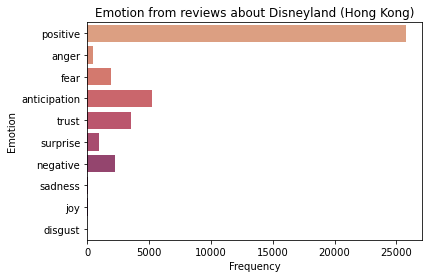

In [37]:
from pylab import savefig

graph = sns.countplot(y="emotion", data=df, palette="flare")
graph.set(xlabel='Frequency', ylabel='Emotion', title = 'Emotion from reviews about Disneyland (Hong Kong)')

figure = graph.get_figure()    
#figure.savefig('output/emotion.jpg', dpi=300, bbox_inches='tight')

#### Find reviews where ngram occurs

In [41]:
specific_words = ['space mountain']
query = '|'.join(specific_words)
df['query_match'] = df['Review_Text'].str.lower().str.contains(query)
df.head()


,Rating,Reviewer_Location,Review_Text,Branch,year,month,tb_polarity,tb_subjectivity,vader_pos,vader_neg,vader_comp,sentiment,emotion,query_match
0,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,0.243981,0.561481,0.109,0.000,0.7069,positive,positive,False
1,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,0.236131,0.434649,0.195,0.044,0.9853,positive,positive,True
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,0.160498,0.422944,0.220,0.022,0.9920,positive,positive,False
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,0.189286,0.512143,0.154,0.078,0.8425,positive,positive,False
4,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,0.266667,0.437500,0.098,0.000,0.2846,positive,anger,False


In [42]:
#what are people saying about space mountain?
space_sample = df[df['query_match'] == True]

In [43]:
#do ngram association again

space_reviews = space_sample['Review_Text']
space_reviews = space_reviews.astype('str')
eng_rev1 = space_reviews[space_reviews.apply(get_language)]
eng_rev1.drop_duplicates(inplace=True)

#apply function to clean and lemmatize comments
lemm1 = eng_rev1.map(clean_comments)

#lowercase words
lemm1 = lemm1.map(lambda x: [word.lower() for word in x])

unlist_rev1 = [item for items in lemm1 for item in items]
cleaned_rev1 = [w for w in unlist_rev1 if not w in stop_words] 

#remove spaces
cleaned_rev1 = [w for w in cleaned_rev1 if w != ' '] 
cleaned_rev1 = [w for w in cleaned_rev1 if w != '  '] 
cleaned_rev1 = [w for w in cleaned_rev1 if w != '   ']

bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

bigramFinder1 = nltk.collocations.BigramCollocationFinder.from_words(cleaned_rev1)
trigramFinder1 = nltk.collocations.TrigramCollocationFinder.from_words(cleaned_rev1)

bigram_freq1 = bigramFinder1.ngram_fd.items()
bigramFreqTable1 = pd.DataFrame(list(bigram_freq1), columns=['bigram','freq']).sort_values(by='freq', ascending=False)


In [44]:
bigramFreqTable1.head(10).reset_index(drop=True)

,bigram,freq
0,"(space, mountain)",3416
1,"(fast, pass)",1607
2,"(indiana, jones)",853
3,"(thunder, mountain)",816
4,"(small, world)",624
5,"(big, thunder)",573
6,"(main, street)",533
7,"(wait, time)",512
8,"(hong, kong)",500
9,"(disneyland, paris)",492


In [45]:
bigram_filter1 = bigramFreqTable1[bigramFreqTable1.bigram.map(lambda x: rightTypes(x))]
bigram_filter1.head(10)

,bigram,freq
47,"(space, mountain)",3416
27090,"(indiana, jones)",853
1424,"(thunder, mountain)",816
2319,"(small, world)",624
1895,"(big, thunder)",573
94,"(main, street)",533
533,"(wait, time)",512
329,"(hong, kong)",500
774,"(disneyland, paris)",492
11664,"(splash, mountain)",471


In [46]:
trigram_freq1 = trigramFinder1.ngram_fd.items()
trigramFreqTable1 = pd.DataFrame(list(trigram_freq1), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable1.head(10).reset_index(drop=True)

,trigram,freq
0,"(big, thunder, mountain)",448
1,"(ride, space, mountain)",336
2,"(get, fast, pass)",281
3,"(use, fast, pass)",192
4,"(mountain, indiana, jones)",173
5,"(hong, kong, disneyland)",170
6,"(indiana, jones, ride)",151
7,"(fast, pass, system)",129
8,"(space, mountain, ride)",128
9,"(toy, story, land)",127


In [47]:
bigram_filter1 = bigramFreqTable1[bigramFreqTable1.bigram.map(lambda x: rightTypes(x))]

test_string4 = bigram_filter1['bigram'].tolist()

bigram1 = [ ]
for c in range(0, len(test_string4)):
    bigram1.append(test_string4[c][0] + '_' + test_string4[c][1]) 

bigram_filter1['bigram_combo'] = bigram1
top20_bigram1 = bigram_filter1[:20]

<ipython-input-47-00b0f0531b41>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigram_filter1['bigram_combo'] = bigram1


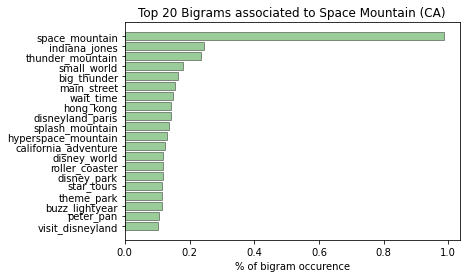

In [48]:
plt.barh(top20_bigram1['bigram_combo'], top20_bigram1['freq']/len(space_sample), color ='green', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of bigram occurence")
plt.gca().invert_yaxis()
plt.title("Top 20 Bigrams associated to Space Mountain (CA)")
#plt.savefig("output\ca_smallworld_topbigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

In [49]:
trigram_filter1 = trigramFreqTable1[trigramFreqTable1.trigram.map(lambda x: rightTypes(x))]

test_string3 = trigram_filter1['trigram'].tolist()

trigram1 = [ ]
for c in range(0, len(test_string3)):
    trigram1.append(test_string3[c][0] + '_' + test_string3[c][1] + '_' + test_string3[c][2]) 

trigram_filter1['trigram_combo'] = trigram1
top20_trigram1 = trigram_filter1[:20]

<ipython-input-49-50d5f67ab967>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trigram_filter1['trigram_combo'] = trigram1


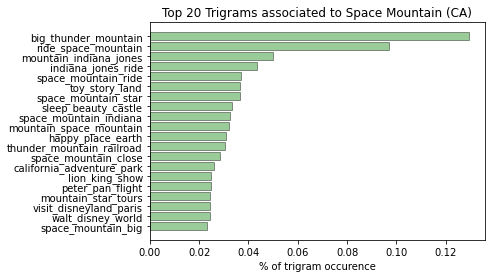

In [50]:
plt.barh(top20_trigram1['trigram_combo'], top20_trigram1['freq']/len(space_sample), color ='green', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of trigram occurence")
plt.gca().invert_yaxis()
plt.title("Top 20 Trigrams associated to Space Mountain (CA)")
#plt.savefig("output\ca_smallworld_toptrigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

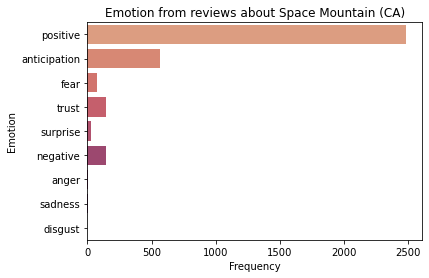

In [51]:
graph = sns.countplot(y="emotion", data=space_sample, palette="flare")
graph.set(xlabel='Frequency', ylabel='Emotion', title = 'Emotion from reviews about Space Mountain (CA)')
figure = graph.get_figure() 
#figure.savefig('output/ca_spacemtn_emotion.jpg', dpi=300, bbox_inches='tight')

In [52]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [53]:
text = " ".join(review for review in space_sample.Review_Text)
tokenizer = RegexpTokenizer(r'\w+')
text = text.lower()
cleaned_text = re.sub('\W', ' ', text)
#stopword = stopwords.words("english")
stopwords = set(STOPWORDS)
stopwords.update(["space", "mountain", "t", "s", "hong", "kong"])
snowball_stemmer = SnowballStemmer("english")
word_tokens = nltk.word_tokenize(cleaned_text)
stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
processed_text = [word for word in stemmed_word if word not in stopwords]

#get adjectives only
tags = nltk.pos_tag(processed_text)
adjs = [word for word,pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS')]
text_string=(" ").join(adjs)

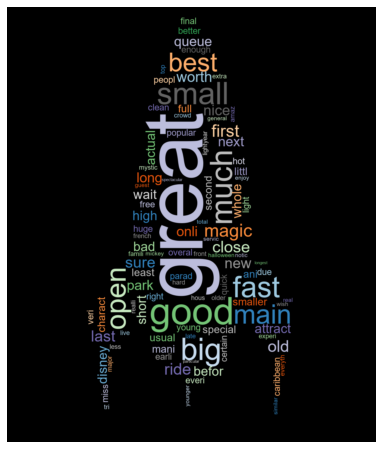

In [54]:
mask = np.array(Image.open("images/rocket.jpg"))
wordcloud = WordCloud(mask = mask, stopwords = stopwords, background_color="black", font_path='arial', 
                      max_words = 100, scale = 3, #contour_width = 1,
                     max_font_size = 100).generate(text_string)
#image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud.recolor(colormap = 'tab20c' 
                            ) , interpolation="bilinear")
plt.axis("off")
plt.savefig("output/fr_spacemtn_wc.jpg", bbox_inches='tight', dpi = 300)
plt.show()

#### Topic Modeling

In [55]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Marielle\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [56]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.Review_Text.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
data_words = list(sent_to_words(data))
#data_words[:1]

In [57]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['if', 'youve', 'ever', 'been', 'to', 'disneyland', 'anywhere', 'youll', 'find', 'disneyland_hong_kong', 'very', 'similar', 'in', 'the', 'layout', 'when', 'you', 'walk', 'into', 'main_street', 'it', 'has', 'very', 'familiar', 'feel', 'one', 'of', 'the', 'rides', 'its', 'small', 'world', 'is', 'absolutely', 'fabulous', 'and', 'worth', 'doing', 'the', 'day', 'we', 'visited', 'was', 'fairly', 'hot', 'and', 'relatively', 'busy', 'but', 'the', 'queues', 'moved', 'fairly', 'well']


In [58]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [59]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ve', 'ever', 'disneyland', 'anywhere', 'find', 'disneyland', 'similar', 'layout', 'walk', 'main_street', 'familiar', 'feel', 'ride', 'small', 'world', 'absolutely', 'fabulous', 'worth', 'day', 'visit', 'fairly', 'hot', 'relatively', 'busy', 'queue', 'move', 'fairly', 'well']]


In [60]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [61]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [62]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.049*"meal" + 0.046*"meet" + 0.037*"breakfast" + 0.027*"smoke" + 0.022*"poor" + 0.017*"cafe" + 0.017*"table" + 0.016*"dlp" + 0.015*"dinner" + 0.013*"voucher"'), (1, '0.050*"french" + 0.040*"room" + 0.031*"ask" + 0.027*"son" + 0.023*"tell" + 0.020*"france" + 0.019*"face" + 0.014*"site" + 0.011*"appear" + 0.010*"door"'), (2, '0.046*"get" + 0.041*"day" + 0.040*"go" + 0.037*"ride" + 0.035*"queue" + 0.031*"time" + 0.022*"take" + 0.018*"hotel" + 0.017*"wait" + 0.015*"long"'), (3, '0.085*"see" + 0.061*"show" + 0.055*"parade" + 0.054*"character" + 0.030*"studio" + 0.026*"night" + 0.023*"amazing" + 0.021*"magical" + 0.019*"castle" + 0.017*"firework"'), (4, '0.061*"park" + 0.043*"disney" + 0.022*"good" + 0.021*"disneyland" + 0.020*"food" + 0.017*"visit" + 0.016*"paris" + 0.015*"well" + 0.015*"do" + 0.014*"really"'), (5, '0.071*"child" + 0.065*"kid" + 0.065*"great" + 0.055*"year" + 0.052*"place" + 0.043*"love" + 0.041*"old" + 0.034*"enjoy" + 0.027*"fun" + 0.027*"family"'), (6, '0.100*"ride

In [63]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.120861090752575

Coherence Score:  0.3754433398840718


In [64]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.269910  0.040958       1        1  37.552230
2      0.251283 -0.055661       2        1  29.915523
5      0.033850  0.366230       3        1   9.251926
3     -0.125668 -0.063818       4        1   8.769093
6      0.053453 -0.294280       5        1   8.450795
0     -0.251824  0.011379       6        1   3.123317
1     -0.231005 -0.004807       7        1   2.937116, topic_info=           Term          Freq         Total Category  logprob  loglift
17         ride  44807.000000  44807.000000  Default  30.0000  30.0000
73         park  52587.000000  52587.000000  Default  29.0000  29.0000
195         see  16918.000000  16918.000000  Default  28.0000  28.0000
53          get  31650.000000  31650.000000  Default  27.0000  27.0000
41       disney  36871.000000  36871.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
578   selection    328.924903    329.508199   Topic7  -5.3146   3.5260
1757      block    322.787286    323.371105   Topic7  -5.3334   3.5259
1168     driver    319.104989    319.689118   Topic7  -5.3449   3.5259
560        tell   1568.741811   2972.883957   Topic7  -3.7524   2.8885
705        hand    396.090963   1210.875454   Topic7  -5.1288   2.4103

[297 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         4  0.999601  absolutely
435       3  0.999794       adult
344       3  0.999801         age
27        1  0.392769        also
27        2  0.490887        also
...     ...       ...         ...
25        3  0.018233       worth
25        4  0.247196       worth
1603      3  0.999897       wrong
434       3  0.999969        year
338       3  0.999794       young

[338 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 4, 7, 1, 2])